# FloPy MODPATH 7 structured transient model

This notebook reproduces example 3a from the MODPATH 7 documentation, demonstrating a transient MODFLOW 6 simulation based on the same flow system as the basic structured and unstructured examples. Particles are released at 10 20-day intervals for the first 200 days of the simulation. 2 discharge wells are added 100,000 days into the simulation and pump at a constant rate for the remainder. There are three stress periods:

| Stress period | Type         | Time steps | Length (days) |
|:--------------|:-------------|:-----------|:--------------|
| 1             | steady-state | 1          | 100000        |
| 2             | transient    | 10         | 36500         |
| 3             | steady-state | 1          | 100000        |

## Setting up the simulation

First import FloPy and set up a temporary workspace.

In [181]:
import sys
import os
from os.path import join
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

temp_dir = TemporaryDirectory()
sim_name = "mp7_ex03a_mf6"
workspace = os.path.join(temp_dir.name, sim_name)

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
numpy version: 1.24.1
matplotlib version: 3.6.3
flopy version: 3.3.7


Define flow model data.

In [182]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]
laytyp = [1, 0, 0]
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]
rch = 0.005
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5

Define well data. Although this notebook will refer to layer/row/column indices starting at 1, indices in FloPy (and more generally in Python) are zero-based. A negative discharge indicates pumping, while a positive value indicates injection.

In [183]:
wells = [
    # layer, row, col, discharge
    (0, 10, 9, -75000),
    (2, 12, 4, -100000)
]

Define the drain location.

In [184]:
drain = (0, 14, (9, 20))

Configure locations for particle tracking to terminate. We have three explicitly defined termination zones:

- `2`: the well in layer 1, at row 11, column 10
- `3`: the well in layer 3, at row 13, column 5
- `4`: the drain in layer 1, running through row 15 from column 10-20

MODFLOW 6 reserves zone number `1` to indicate that particles may move freely within the zone.

The river running through column 20 is also a termination zone, but it doesn't need to be defined separately since we are using the RIV package.

In [185]:
zone_maps = []

# zone 1 is the default (non-terminating regions)
def fill_zone_1():
    return np.ones((nrow, ncol), dtype=np.int32)

# zone map for layer 1
za = fill_zone_1()
za[wells[0][1:3]] = 2
za[drain[1], drain[2][0]:drain[2][1]] = 4
zone_maps.append(za)

# constant layer 2 (zone 1)
zone_maps.append(1)

# zone map for layer 3
za = fill_zone_1()
za[wells[1][1:3]] = 3
zone_maps.append(za)

Define particles to track. We release particles from the top of a 2x2 square of cells in the upper left of the model grid's top layer.

In [186]:
rel_minl = rel_maxl = 1
rel_minr = 2
rel_maxr = 3
rel_minc = 2
rel_maxc = 3
sd = flopy.modpath.CellDataType(drape=0)  # particles added at top of cell (no drape)
pd = flopy.modpath.LRCParticleData(
    subdivisiondata=[sd],
    lrcregions=[
        [[rel_minl, rel_minr, rel_minc, rel_maxl, rel_maxr, rel_maxc]]
    ]
)
pg = flopy.modpath.ParticleGroupLRCTemplate(
    particlegroupname="PG1",
    particledata=pd,
    filename=f"{sim_name}.pg1.sloc"
)
pgs = [pg]
defaultiface = {"RECHARGE": 6, "ET": 6}

Create the MODFLOW 6 simulation.

In [187]:
# simulation
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name, exe_name="mf6", version="mf6", sim_ws=workspace
)

# temporal discretization
nper = 3
pd = [
    # perlen, nstp, tsmult
    (100000, 1, 1),
    (36500, 10, 1),
    (100000, 1, 1)
]
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=pd
)

# groundwater flow (gwf) model
model_nam_file = "{}.nam".format(sim_name)
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=sim_name, model_nam_file=model_nam_file, save_flows=True
)

# iterative model solver (ims) package
ims = flopy.mf6.modflow.mfims.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    outer_dvclose=1e-6,
    inner_dvclose=1e-6,
    rcloserecord=1e-6,
)

# grid discretization
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

# initial conditions
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

# node property flow
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=laytyp, k=kh, k33=kv
)

# recharge
rch = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rch)

# wells
def no_flow(w):
    return w[0], w[1], w[2], 0

wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf, maxbound=1, stress_period_data={
    0: [no_flow(w) for w in wells],
    1: wells,
    2: wells
})

# river
rd = [[(0, i, ncol - 1), riv_h, riv_c, riv_z] for i in range(nrow)]
flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, stress_period_data={0: rd, 1: rd, 2: rd})

# drain (set auxiliary IFACE var to 6 for top of cell)
dd = [[
    drain[0],
    drain[1],
    i + drain[2][0],
    322.5,
    100000.,
    6] for i in range(drain[2][1] - drain[2][0])]
drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf, stress_period_data={0: dd})

# output control
headfile = "{}.hds".format(sim_name)
head_record = [headfile]
budgetfile = "{}.cbb".format(sim_name)
budget_record = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_record,
    budget_filerecord=budget_record,
)

Take a look at the model grid before running the simulation.

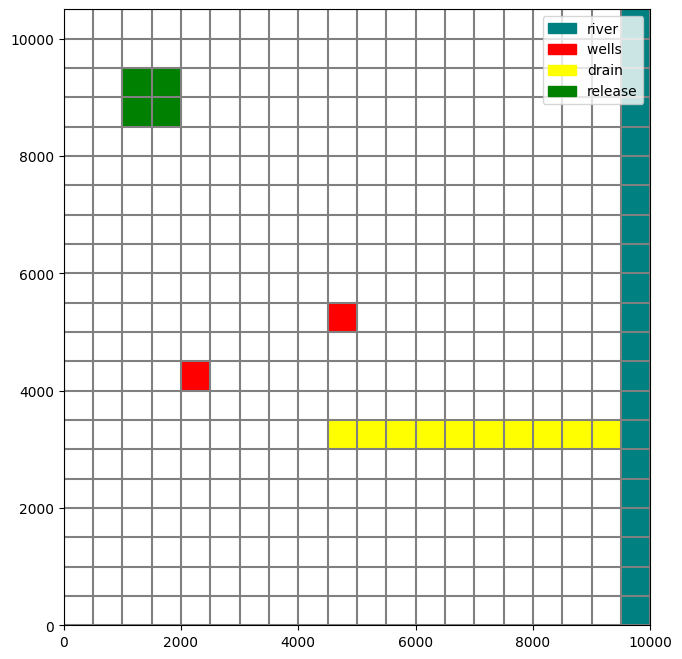

In [188]:
def add_release(ax):
    ax.add_patch(mpl.patches.Rectangle(
        (2 * delc, (nrow - 2) * delr),
        1000,
        -1000,
        facecolor="green",
    ))

def add_legend(ax):
    ax.legend(handles=[
        mpl.patches.Patch(color="teal", label="river"),
        mpl.patches.Patch(color="red", label="wells "),
        mpl.patches.Patch(color="yellow", label="drain"),
        mpl.patches.Patch(color="green", label="release"),
    ])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mv = flopy.plot.PlotMapView(model=gwf)
mv.plot_grid()
mv.plot_bc("DRN")
mv.plot_bc("RIV")
mv.plot_bc("WEL", plotAll=True)  # include both wells (1st and 3rd layer)
add_release(ax)
add_legend(ax)
plt.show()

# Running the simulation

Run the MODFLOW 6 flow simulation.

In [189]:
sim.write_simulation()
success, buff = sim.run_simulation(silent=True, report=True)
assert success, "Failed to run simulation."
for line in buff:
    print(line)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mp7_ex03a_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 11 based on size of stress_period_data
    writing package oc...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 04:48:56 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for appl

Create and run MODPATH 7 particle tracking model in `combined` mode, which includes both pathline and timeseries.

In [190]:
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=sim_name + "_mp", flowmodel=gwf, exe_name="mp7", model_ws=workspace
)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="forward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.9],
    timepointdata=[10, 20.0],  # release every 20 days, for 200 days
    zonedataoption="on",
    zones=zone_maps,
    particlegroups=pgs,
)

mp.write_input()
success, buff = mp.run_model(silent=True, report=True)
assert success
for line in buff:
    print(line)


MODPATH Version 7.2.001   
Program compiled Dec 10 2022 04:51:18 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+05  Steady-state flow                                                    
Processing Time Step     1 Period     2.  Time =  1.03650E+05  Steady-state flow                                                    
Processing Time Step     2 Period     2.  Time =  1.07300E+05  Steady-state flow                                                    
Processing Time Step     3 Period     2.  Time =  1.10950E+05  Steady-state flow                                                    
Processing Time Step     4 Period     2.  Time =  1.14600E+05  Steady-state flow                                                    
Processing Time Step     5 Period     2.  Time =  1.18250E+05  Steady-state flow                                                    
Processing Time Step     6 Period     2.  Time =  1.

## Inspecting results

First we need the particle termination locations.

In [191]:
wel_locs = [w[0:3] for w in wells]
riv_locs = [(0, i, 19) for i in range(20)]
drn_locs = [(drain[0], drain[1], d) for d in range(drain[2][0], drain[2][1])]
wel_nids = gwf.modelgrid.get_node(wel_locs)
riv_nids = gwf.modelgrid.get_node(riv_locs)
drn_nids = gwf.modelgrid.get_node(drn_locs)

Next, load pathline data from the MODPATH 7 pathline output file, filtering by termination location.

In [192]:
fpth = os.path.join(workspace, sim_name + "_mp.mppth")
p = flopy.utils.PathlineFile(fpth)

pl1 = p.get_destination_pathline_data(wel_nids, to_recarray=True)
pl2 = p.get_destination_pathline_data(riv_nids + drn_nids, to_recarray=True)

Load endpoint data from the MODPATH 7 endpoint output file.

In [193]:
fpth = os.path.join(workspace, sim_name + "_mp.mpend")
e = flopy.utils.EndpointFile(fpth)

ep1 = e.get_destination_endpoint_data(dest_cells=wel_nids)
ep2 = e.get_destination_endpoint_data(dest_cells=riv_nids + drn_nids)

Extract head data from the GWF model's output files.

In [194]:
hf = flopy.utils.HeadFile(join(workspace, f"{sim_name}.hds"))
head = hf.get_data()

Plot heads over a map view of the model, then add particle starting points and pathlines. The apparent number of particle starting locations is less than the total number of particles because a separate particle begins at each location every 20 days during the release period at the beginning of the simulation.

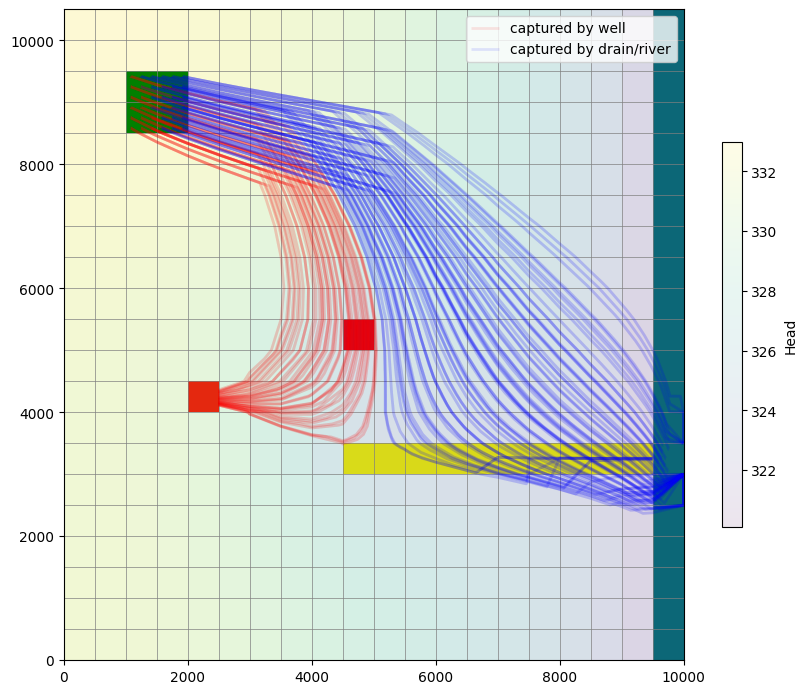

In [195]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

mv = flopy.plot.PlotMapView(model=gwf)
mv.plot_grid(lw=0.5)
mv.plot_bc("DRN")
mv.plot_bc("RIV")
mv.plot_bc("WEL", plotAll=True)
hd = mv.plot_array(head, alpha=0.1)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label('Head')
mv.plot_pathline(pl1, layer="all", alpha=0.1, colors=["red"], lw=2, label="captured by well")
mv.plot_pathline(pl2, layer="all", alpha=0.1, colors=["blue"], lw=2, label="captured by drain/river")
add_release(ax)
mv.ax.legend()
plt.show()

Clean up the temporary directory.

In [196]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass